<a href="https://colab.research.google.com/github/greyweb/Yoga_posture_classification/blob/Notebook/Yoga_Posture_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary modules

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import splitfolders
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

### Understanding Data

In [ ]:
labels = []
train_counts = []
for dirname in os.listdir('DATASET/TRAIN'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('DATASET/TRAIN',dirname)):
        image_count +=1
    train_counts.append(image_count)


In [ ]:
print(labels)
print(train_counts)

['downdog', 'tree', 'warrior2', 'goddess', 'plank']
[223, 160, 252, 180, 266]


### Splitting Train -> Train and Validation (80-20 split)

###  ! Run This only once

In [ ]:
#chmod -R 777 /absolute/path/to/your/folder --> IN case the folder is in Read only mode.

# root_dir = "DATASET"
# labels # Contains the 5 different yoga postures
# for ele in labels:
#     os.makedirs(root_dir+'/VALID/'+ele)

### Using Split_Folders Library   !Run this Only Once!

In [ ]:
# os.makedirs("DATA")
# input_folder = 'DATASET/TRAIN'
# output_folder = 'DATA'
# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2), group_prefix=None)

In [ ]:
#os.makedirs("DATA/test")

## Moving Test File to the New Folder

### !Run this Only Once!

In [ ]:
# source = 'DATASET/TEST'
# destination= 'DATA/test'
# dest = shutil.move(source, destination)  

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory("DATA/train",
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(150, 150),
                                                    shuffle=True)


valid_generator = valid_datagen.flow_from_directory("DATA/val",
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)

Found 863 images belonging to 5 classes.
Found 218 images belonging to 5 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'DATA/test/TEST',
  batch_size=1,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False
    
)


Found 470 images belonging to 5 classes.


### Assigning weights to classes

In [ ]:
class_weights = []
total_samples = train_generator.samples
total_classes = len(train_generator.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))
print(class_weights)

{0: 0.77, 1: 1.08, 2: 0.68, 3: 0.96, 4: 0.65}


### Clearing weights to avoid overfitting

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

### Model - Pre trained (Xception)

In [ ]:
def custom_model():
    
    
    cus_model = VGG19(input_shape = (150,150,3),         #keras.applications.xception.Xception
                         weights='imagenet', 
                         include_top=False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = layers.Flatten()(cus_model.output)

    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.Dropout(0.2)(x)
 
    x = layers.Dense(5, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

### Structure of the Model

In [ ]:
model = custom_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

### Callbacks:

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("yoga_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

### Compiling the Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



### Fitting the Model

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[checkpoint_cb, lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
54/54 [==============================] - 80s 1s/step - loss: 1.2855 - accuracy: 0.5933 - val_loss: 0.5447 - val_accuracy: 0.8119
Epoch 2/30
54/54 [==============================] - 79s 1s/step - loss: 0.4727 - accuracy: 0.8494 - val_loss: 0.4197 - val_accuracy: 0.8440
Epoch 3/30
54/54 [==============================] - 78s 1s/step - loss: 0.3607 - accuracy: 0.8911 - val_loss: 0.3415 - val_accuracy: 0.8716
Epoch 4/30
54/54 [==============================] - 78s 1s/step - loss: 0.3061 - accuracy: 0.9131 - val_loss: 0.3467 - val_accuracy: 0.8670
Epoch 5/30
54/54 [==============================] - 79s 1s/step - loss: 0.2659 - accuracy: 0.9328 - val_loss: 0.3226 - val_accuracy: 0.8899
Epoch 6/30
54/54 [==============================] - 79s 1s/step - loss: 0.2396 - accuracy: 0.9363 - val_loss: 0.3097 - val_accuracy: 0.9037
Epoch 7/30
54/54 [==============================] - 79s 1s/step - loss: 0.2083 - accuracy: 0.9502 - val_loss: 0.3068 - val_accuracy: 0.9037
Epoch 8/30
54/54 [==

### Graph betweeen Training accuracy and validation accuracy

<Figure size 432x288 with 0 Axes>

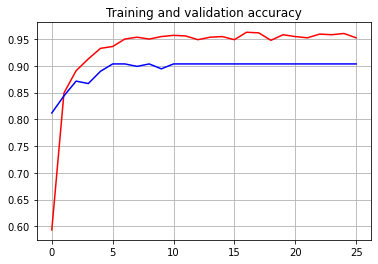

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()


### Graph between Training Loss and Validation Loss

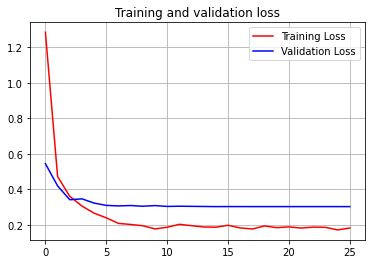

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Graph for Learning rate ~ Exponential Decay

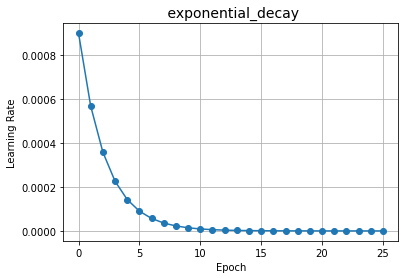

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(" exponential_decay", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
model.evaluate(test_generator, batch_size=1)

470/470 [==============================] - 45s 96ms/step - loss: 0.1284 - accuracy: 0.9702


[0.1283741444349289, 0.9702127575874329]

(0.0, 1.0)

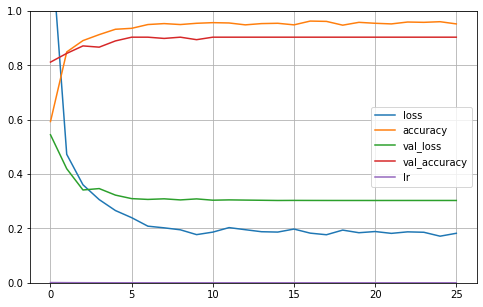

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [ ]:
model.save("Yoga_Posture_model.h5")

In [ ]:

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        97
           1       0.96      0.95      0.96        80
           2       0.96      0.98      0.97       115
           3       0.97      0.99      0.98        69
           4       0.98      0.98      0.98       109

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



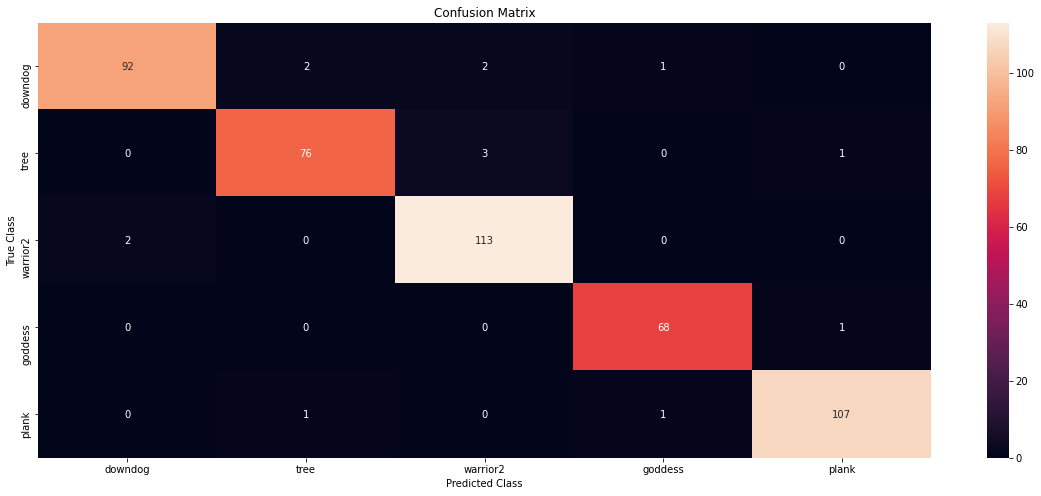

In [ ]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
Labels = ['downdog', 'tree', 'warrior2', 'goddess', 'plank']
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()